# Smoothing

<img src="media/cover.png" style="width: 40%; display: block; margin: auto;">

## Introduction

In the previous lectures, we learned that:
- A time series consists of measurements characterized by temporal dependencies.
- The measurements are (usually) collected at equally-spaced intervals.
- A time series can be decomposed into trend, seasonality, and residuals.
- Many time series models require the data to be stationary in order to make forecasts.  

- In this lecture, we will build upon that knowledge and explore another important concept called **smoothing**.
- In particular, we will cover:
    1. An introduction to smoothing and why it is necessary.
    2. Common smoothing techniques.
    3. How to smooth time series data with Python and generate forecasts.

In [4]:
import sys

# Install dependencies if the notebook is running in Colab
if 'google.colab' in sys.modules:
    !pip install -U -qq tsa-course

In [5]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from io import BytesIO
#from last lecture:
def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax
np.random.seed(0) # reproducibility

---

## Smoothing

- A data collection process is often affected by noise. 
- If too strong, the noise can conceal useful patterns in the data. 
- Smoothing is a well-known and often-used technique to recover those patterns by *filtering out noise*.
- It can also be used to *make forecasts* by projecting the recovered patterns into the future.

- We will explore two important techniques to do smoothing:
    1. Simple smoothing.
    2. Exponential smoothing.

- We start by generating some stationary data.
- We discussed the importance of visually inspecting the time series with a run-sequence plot. 
- So, we will also define the `run_sequence_plot` function to visualize our data.

In [6]:
# Generate stationary data
time = np.arange(100)
stationary = np.random.normal(loc=0, scale=1.0, size=len(time))

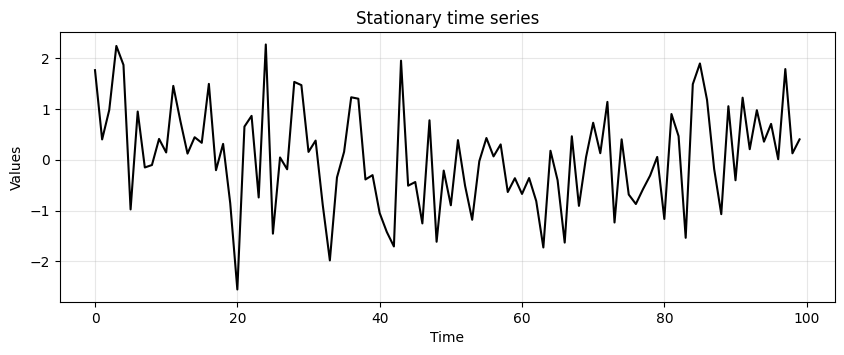

In [7]:
run_sequence_plot(time, stationary, title="Stationary time series");


---

## Simple smoothing techniques

- There are many techniques for smoothing data. 
- The most simple ones are:
    1. Simple average
    2. Moving average
    3. Weighted moving average

### Simple average

- Simple average is the most basic technique. 
- Consider the stationary data above.
- The most conservative way to represent it is through its **mean**.
- The mean can be used to predict the future values of the time series.
- This type of representation is called *simple average*.

In [8]:
# find mean of series
stationary_time_series_avg = np.mean(stationary)

# create array composed of mean value and equal to length of time array
sts_avg = np.full(shape=len(time), fill_value=stationary_time_series_avg, dtype='float')

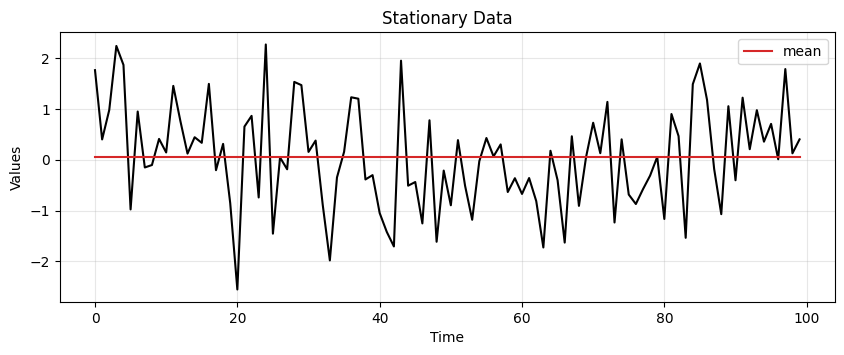

In [9]:
ax = run_sequence_plot(time, stationary, title="Stationary Data")
ax.plot(time, sts_avg, 'tab:red', label="mean")
plt.legend();

### Mean squared error (MSE)

- The approximation with the mean seems reasonable in this case.
- In general we want to measure how far off our estimate is from reality. 
- A common way of doing it is by calculating the *Mean Squared Error* (MSE) 

$$MSE = \frac{1}{T}\sum_{t=1}^{T} (X(t) - \hat{X}(t))^2$$

- where $X(t)$ and $\hat{X}(t)$ are the true and estimated values at time $t$, respectively. 

**Example**

- Let's consider the following example.
- Say we have a time series of observed values $X = [0, 1, 3, 2]$.
- The predictions given by our model are $\hat{X} =  [1, 1, 2, 4]$. 
- We calculate the MSE as: 

$$\frac{(0-1)^{2} + (1-1)^{2} + (3-2)^{2} + (2-4)^{2}}{4} = 1.5$$

- Say we had another model that give us the estimate $\hat{X} =  [0, 0, 1, 0]$.
- The MSE in this case is: 

$$\frac{0^{2} + 1^{2} + 2^{2} + 2^{2}}{4} = 2.25$$

- The MSE allows to compare different estimates to see which is best. 
- In this case, the first model gives us a better estimate than the second one. 
- This idea of measuring how a model performs is important in machine learning and we will use it often in this course.
- Let's create a function to calculate MSE that we will use as we go forward.

In [10]:
def mse(observations, estimates):

    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = np.mean(sq_diff)
    
    return mse

Let's test the ``mse`` function.

In [11]:
zeros = mse(np.array([0, 1, 3, 2]), np.array([1, 1, 2, 4]))
print(zeros)

1.5


In [12]:
ones = mse(np.array([0, 1, 3, 2]), np.array([0, 0, 1, 0]))
print(ones)

2.25


- Next, we add a *trend* to our stationary time series.

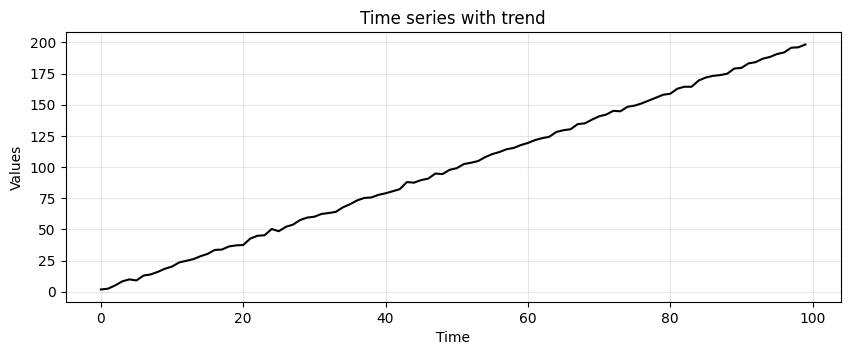

In [13]:
trend = (time * 2.0) + stationary
run_sequence_plot(time, trend, title="Time series with trend");

- Suppose we use again the simple average to represent the time series.

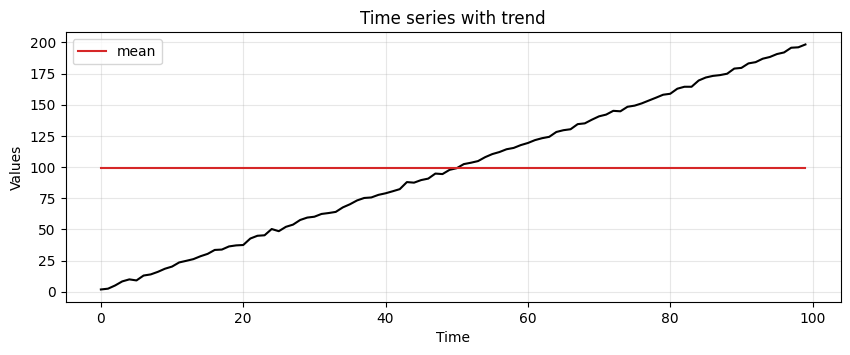

In [14]:
# find mean of series
trend_time_series_avg = np.mean(trend)

# create array of mean value equal to length of time array
avg_trend = np.full(shape=len(time), fill_value=trend_time_series_avg, dtype='float')

run_sequence_plot(time, trend, title="Time series with trend")
plt.plot(time, avg_trend, 'tab:red', label="mean")
plt.legend();

- Clearly, the simple average does not work well in this case.
- We must find other ways to capture the underlying pattern in the data. 
- We start with something called a *moving average*.

### Moving Average (MA)

- Moving average has a greater sensitivity than the simple average to local changes in the data.
- The easiest way to understand moving average is by example. 
- Say we have the following values:

<img src="media/values.png" style="width: 30%; display: block; margin: auto;">

- The first step is to select a window size. 
- We'll arbitrarily choose a size of 3. 
- Then, we start computing the average for the first three values and store the result. 
- We then slide the window by one and calculate the average of the next three values. 
- We repeat this process until we reach the final observed value. 

<img src="media/EqWMA.gif" style="width: 40%; display: block; margin: auto;">

- Now, let's define a function to perform smoothing with the MA.
- Then, we compare the MSE obtained from applying simple and moving average on the data with trend. 

In [15]:
def moving_average(observations, window=3, forecast=False):
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    ma = cumulative_sum[window - 1:] / window
    if forecast:
        observations = np.append(observations, np.nan)
        ma_forecast = np.insert(ma, 0, np.nan*np.ones(window))
        return observations, ma_forecast
    else:
        return ma

In [16]:
MA_trend = moving_average(trend, window=3)

print(f"MSE:\n--------\nsimple average: {mse(trend, avg_trend):.2f}\nmoving_average: {mse(trend[2:], MA_trend):.2f}")

MSE:
--------
simple average: 3324.01
moving_average: 4.57


- Clearly, the MA manages to pick up much better the trend data.
- We can also plot the result against the actual time series.

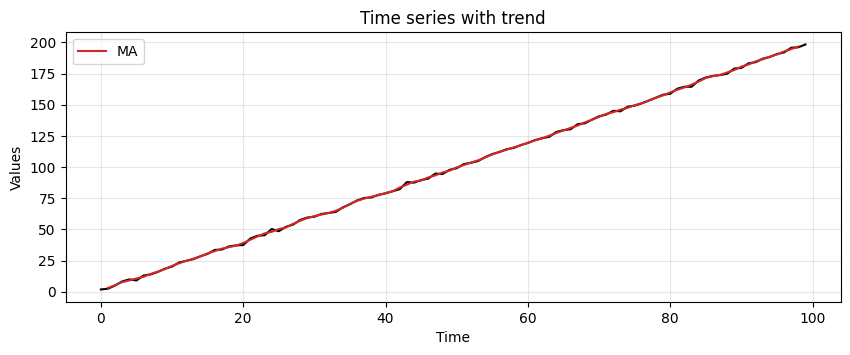

In [17]:
run_sequence_plot(time, trend, title="Time series with trend")
plt.plot(time[1:-1], MA_trend, 'tab:red', label="MA")
plt.legend();

- Note that the output of the MA is shorter than the original data.
- The reason is that the moving window is not centered on the first and last elements of the time series.
- Given a window of size $P$, the MA will be $P-1$ steps shorter than the original time series.

In [18]:
x = np.arange(20)
print(len(moving_average(x, window=9)))

12


- Now, we try the MA on a periodic time series, which could represent a seasonality.

In [19]:
seasonality = 10 + np.sin(time) * 10 + stationary
MA_seasonality = moving_average(seasonality, window=3)

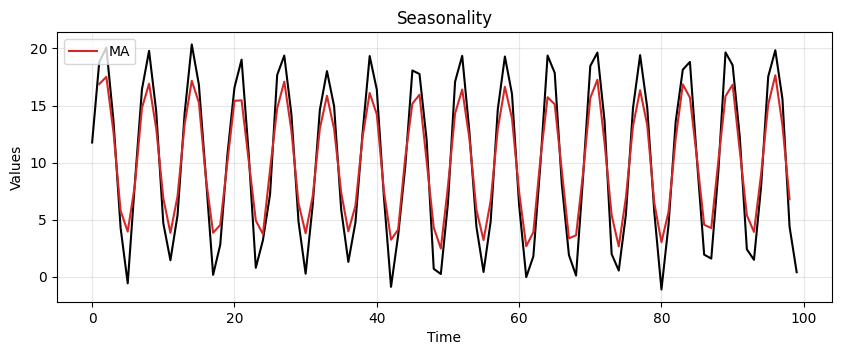

In [20]:
run_sequence_plot(time, seasonality, title="Seasonality")
plt.plot(time[1:-1], MA_seasonality, 'tab:red', label="MA")
plt.legend(loc='upper left');

- It's not perfect but clearly picks up the periodic pattern.
- Lastly, let's see how MA handles trend, seasonality, and a bit of noise.

In [21]:
trend_seasonality = trend + seasonality + stationary
MA_trend_seasonality = moving_average(trend_seasonality, window=3)

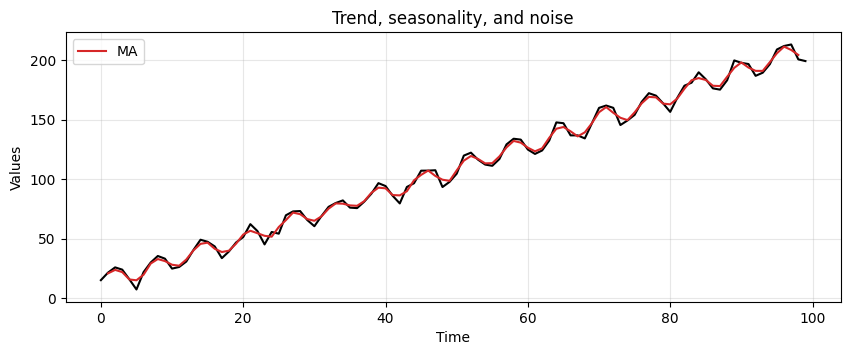

In [22]:
run_sequence_plot(time, trend_seasonality, title="Trend, seasonality, and noise")
plt.plot(time[1:-1], MA_trend_seasonality, 'tab:red', label="MA")
plt.legend(loc='upper left');

- This method is picking up key patterns in these toy datasets. 
- However, it has several limitations.

1. MA assigns equal importance to all values in the window, regardless of their chronological order. 
    - For this reason it fails in capturing the often more relevant recent trends.

2. MA requires the selection of a specific window size, which can be arbitrary and may not suit all types of data. 
 - a small window may lead to noise
 - a too large window could oversmooth the data, missing important short-term fluctuations.

3. MA does not adjust for changes in trend or seasonality. 
    - This can lead to inaccurate predictions, especially when these components are nonlinear and time-dependent.

### Weighted moving average (WMA)

- WMA weights recent observations more than more distant ones. 
- This makes intuitive sense. 
    - Think of the stock market: it has been observed that today's price is a good predictor of tomorrow's price. 
- By applying unequal weights to past observations, we can control how much each affects the future forecast. 

- There are many ways to set the weights.
- For example, we could define them with the following system of equations: 

$$
\begin{cases}
& w_1 + w_2 + w_3 = 1\\ 
& w_2 = (w_1)^2 \\ 
& w_3 = (w_1)^3
\end{cases}
$$

- This gives the following weights:
  
$$
\begin{aligned}
& w_1 \approx 0.543 & \text{weights associated to $t-1$}\\ 
& w_2 \approx 0.294 & \text{weights associated to $t-2$} \\ 
& w_3 \approx 0.16 & \text{weights associated to $t-3$}
\end{aligned}
$$

<img src="media/ExpWMA.gif" style="width: 40%; display: block; margin: auto;">

```{note}

- There are numerous methods to find the optimal weighting scheme based on the data and the task at hand. 
- A full discussion is beyond the scope of the lecture. 
```

### Forecasting with MA

- Instead of pulling out the inherent pattern within a series, the smoothing functions can be used to create *forecasts*. 
- The forecast for the next time step is computed as follows:

$\hat{X}(t+1) = \frac{X(t) + X(t-1) + \dots + X(t-P+1)}{P}$

- where $P$ is the window size of the MA.

- Let's consider the following time series $X= [1, 2, 4, 8, 16, 32, 64]$. 
- In particular, we apply the smoothing process and use the resulting value as forecast for the next time step.
- With the MA technique and a window size $P=3$ we get the following forecast.

In [23]:
x = np.array([1, 2, 4, 8, 16, 32, 64])
ma_x, ma_forecast = moving_average(x, window=3, forecast=True)

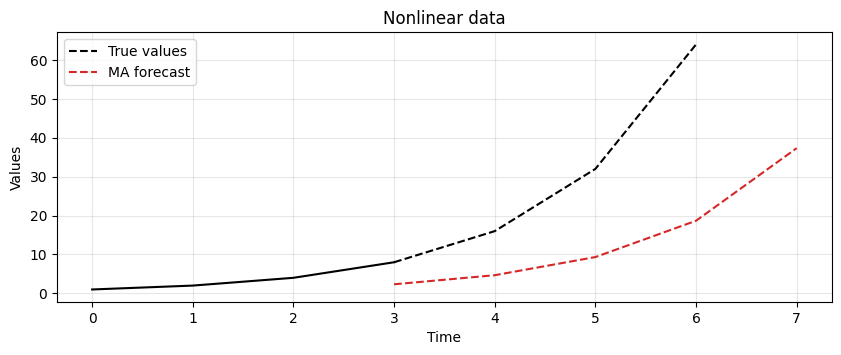

In [24]:
t = np.arange(len(ma_x))
run_sequence_plot(t[:-4], ma_x[:-4], title="Nonlinear data")
plt.plot(t[-5:], ma_x[-5:], 'k', label="True values", linestyle='--')
plt.plot(t, ma_forecast, 'tab:red', label="MA forecast", linestyle='--')
plt.legend(loc='upper left');

- The result shows that MA is lagging behind the actual signal.
- In this case, it is not able to keep up with changes in the trend.
- The lag of MA is also reflected in the forecasts it produces.

- Let's focus on the [forecasting formula](#forecasting-with-ma) we just defined. 
- While easy to understand, one of its properties may not be obvious.
- What's the lag associated with this technique? 
- In other words, after how many time steps do we see a local change in the underlying signal?

- The answer is: $\frac{(P+1)}{2}$. 
- For example, say you're averaging the past 5 values to make the next prediction.
- Then the forecast value that most closely reflects the current value will appear after $\frac{5+1}{2} = 3$ time steps.
- Clearly, the lag increases as you increase the window size for averaging. 

- One might reduce the window size to obtain a more responsive model. 
- However, a window size that's too small will chase noise in the data as opposed to extracting the pattern. 
- There is a tradeoff between *responsiveness* and *robustness to noise*. 
- The best answer lies somewhere in between and requires careful tuning to determine which setup is best for a given dataset and problem at hand. 

- Let's make a practical example to show this tradeoff.
- We will generate some toy data and apply a MA with different window sizes. 
- To make things more clear, we generate again data with trend and seasonality, but we add more noise.

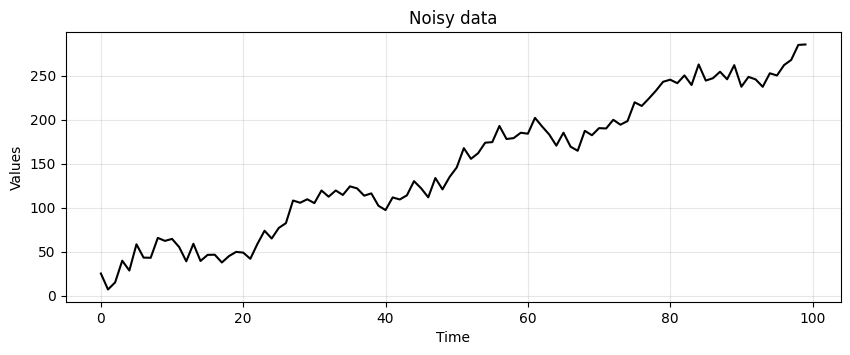

In [25]:
noisy_noise = np.random.normal(loc=0, scale=8.0, size=len(time))
noisy_trend = time * 2.75
noisy_seasonality = 10 + np.sin(time * 0.25) * 20
noisy_data = noisy_trend + noisy_seasonality + noisy_noise

run_sequence_plot(time, noisy_data, title="Noisy data");

In [26]:
# Compute MA with different window sizes
lag_2 = moving_average(noisy_data, window=3)
lag_3 = moving_average(noisy_data, window=5)
lag_5 = moving_average(noisy_data, window=9)
lag_10 = moving_average(noisy_data, window=19)

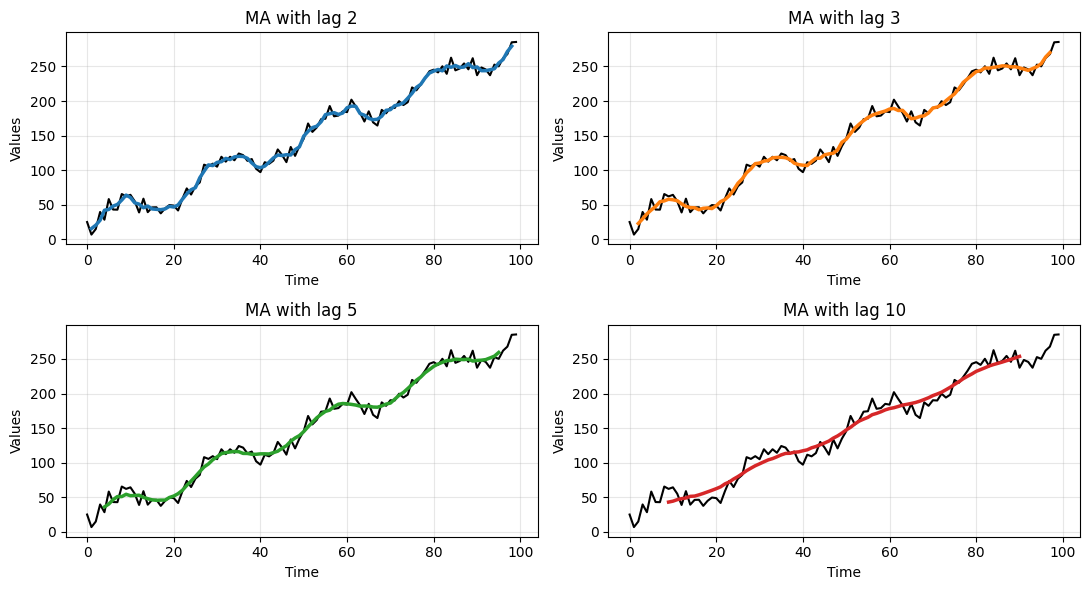

In [27]:
_, axes = plt.subplots(2,2, figsize=(11,6))
axes[0,0] = run_sequence_plot(time, noisy_data, title="MA with lag 2", ax=axes[0,0])
axes[0,0].plot(time[1:-1], lag_2, color='tab:blue', linewidth=2.5)
axes[0,1] = run_sequence_plot(time, noisy_data, title="MA with lag 3", ax=axes[0,1])
axes[0,1].plot(time[2:-2], lag_3, color='tab:orange', linewidth=2.5)
axes[1,0] = run_sequence_plot(time, noisy_data, title="MA with lag 5", ax=axes[1,0])
axes[1,0].plot(time[4:-4], lag_5, color='tab:green', linewidth=2.5)
axes[1,1] = run_sequence_plot(time, noisy_data, title="MA with lag 10", ax=axes[1,1])
axes[1,1].plot(time[9:-9], lag_10, color='tab:red', linewidth=2.5)
plt.tight_layout();

- Clearly, the larger the window size the smoother the data.
- This allows to get rid of the noise but, eventually, also the underlying signal is smoothed out. 

### Forecasting with WMA

- Next, we use the WMA to generate forecasts.
- The previous [forecasting formula](#forecasting-with-ma) is modified to weight differently the past observations in the window:

$$\hat{X}(t+1) = \frac{w_1 \cdot X(t) + w_2 \cdot X(t-1) + \dots + w_P \cdot X(t-P+1)}{P}$$

In [28]:
def weighted_moving_average(observations, weights, forecast=False):
    
    if len(weights) != len(observations[0:len(weights)]):
        raise ValueError("Length of weights must match the window size")
    
    # Normalize weights
    weights = np.array(weights) / np.sum(weights)
    
    # Initialize the result array
    result = np.empty(len(observations)-len(weights)//2)
    result[:] = np.nan
    
    # Calculate weighted moving average
    for i in range(len(weights)//2, len(result)):
        window = observations[i-(len(weights)//2):i+len(weights)//2+1]
        result[i] = np.dot(window, weights)
    
    # Handle forecast option
    if forecast:
        result = np.insert(result, 0, np.nan*np.ones(len(weights)//2+1))
        observations = np.append(observations, np.nan*np.ones(len(weights)//2))
        return observations, result
    else:
        return result

- We repeat the experiment on the same time series $X= [1, 2, 4, 8, 16, 32, 64]$. 
- We will use the set of weights that we defined before, `[0.160, 0.294, 0.543]`.

In [29]:
weights = np.array([0.160, 0.294, 0.543])
wma_x, wma_forecast = weighted_moving_average(x, weights, forecast=True)

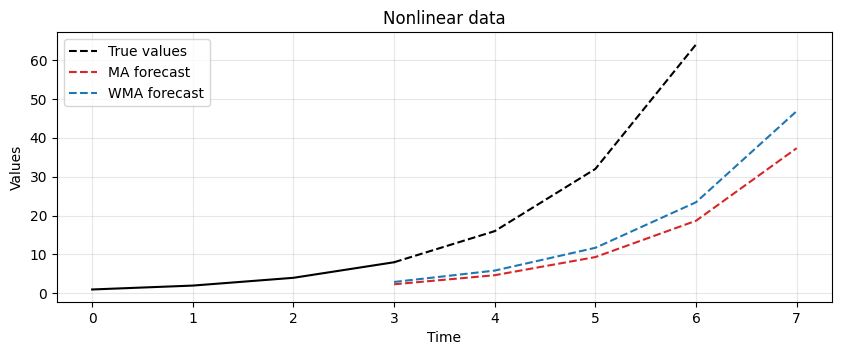

In [30]:
t = np.arange(len(wma_x))
run_sequence_plot(t[:-4], ma_x[:-4], title="Nonlinear data")
plt.plot(t[-5:], ma_x[-5:], 'k', label="True values", linestyle='--')
plt.plot(t, ma_forecast, 'tab:red', label="MA forecast", linestyle='--')
plt.plot(t, wma_forecast, 'tab:blue', label="WMA forecast", linestyle='--')
plt.legend(loc='upper left');

- WMA solves some issues of MA.
    - It is more sensitive to local changes.
    - Is more flexible, as it can adjust the importance of different time steps.
    - It does not require a fixed window size as it applies an exponentially decreasing weight to all past observations.
- However it still struggle in keeping pace with nonlinear and fast-changing trends... There's a significant lag.

---

## Exponential Smoothing

There are three key exponential smoothing techniques:

|Type | Capture trend | Capture seasonality|
|:----:|:---------------:|:--------------------:|
|Single Exponential Smoothing | ❌ | ❌ |
|Double Exponential Smoothing | ✅ | ❌ |
|Triple Exponential Smoothing | ✅ | ✅ |

### Single exponential smoothing

```{tip}
Single Exponential Smoothing is useful if your data lacks trend and seasonality and you want to approximately extract patterns. 
```

- It is analogous to the WMA we saw previously.
- The basic formulation is:

$S(t) = \alpha X(t) + (1-\alpha)S(t-1)$

- where:
    - $S(t)$ is the smoothed value at time *t*,
    - $\alpha$ is a smoothing constant,
    - $X(t)$ is the value of the series at time *t*.

Expanding the formula we get:

$$
\begin{aligned} 
S(0) &= \alpha X(0) \\ S(1) &= \alpha X(1) + (1 - \alpha)S(0) = \alpha X(1) + \alpha(1 - \alpha)X(0) \\
S(2) & = \alpha X(2) + (1 - \alpha)S(1) = \alpha X(2) + (1 - \alpha)[\alpha X(1) + \alpha(1 - \alpha)X(0)]\\
& = \alpha X(2) + \alpha(1 - \alpha)X(1) + \alpha(1 - \alpha)^2 X(0) 
\end{aligned}
$$

The formula for a generic time step $\tau$ is:

$$ S(\tau) = \sum_{t=0}^{\tau} \alpha(1 - \alpha)^{\tau-t}X(t) $$


#### Initialization

- There are many initialization strategies. 
- A simple one is to set $S(0) = X(0)$. 
- Another strategy is to find the mean of the first couple of observations, e.g., $S(0) = \frac{X(0) + X(1) + X(2)}{3}$. 
- Once you've initialized it, you can use the update rule above to calculate all values. 
- In practice, we don't perform this process by hand, but we use the functions in ``statsmodels``. 

#### Setting $\alpha$
- Choosing the optimal value for $\alpha$ is also done by ``statsmodels``. 
- A solver uses a metric like MSE to find the optimal $\alpha$. 
- Even if we do not choose the value manually, is good to have a basic idea of what's happening under the hood.

### Double exponential smoothing

```{tip}
Double Exponential Smoothing has all the benefits of Single Exponential plus the ability to pickup on trend. 
```

$$
\begin{aligned} 
S(t) = \alpha X(t) + (1-\alpha) \big(S(t-1) + b(t-1)\big) & \hspace{2cm} \text{Smoothed values of the series} \\
b(t) = \beta\big(S(t) - S(t-1)\big) + (1 - \beta)b(t-1) & \hspace{2cm} \text{Estimated trend} \\ 
\hat{X}(t+1) = S(t) + b(t) & \hspace{2cm} \text{Forecasts} 
\end{aligned}
$$

- The parameter $\beta \in [0,1]$ controls the decay of the influence of change in the trend.

**Initialization**

- $S(0) = X(0)$.
- $b(0) = X(1) - X(0)$.
- Other initializations are also possible.

**Forecasts beyond 1-step ahead**
- $\hat{X}(t+\tau) = S(t) + \tau b(t)$.

### Triple exponential smoothing

```{tip}
Triple Exponential Smoothing has all the benefits of Double Exponential Smoothing, plus the ability to model the seasonality.
```

- It does this by adding a third component that smooths out seasonality of length $L$.
- There are two variants in the model:
    - additive seasonality,
    - multiplicative seasonality.

**Additive seasonality model**

- This method is preferred when the seasonal variations are roughly constant through the series.

$$
\begin{aligned} 
S(t) = \alpha \big(X(t) - c(t-L)\big) + (1-\alpha) \big(S(t-1) + b(t-1)\big) & \hspace{2cm} \text{Smoothed values} \\
b(t) = \beta\big(S(t) - S(t-1)\big) + (1 - \beta)b(t-1) & \hspace{2cm} \text{Estimated trend} \\ 
c(t) = \gamma \big(X(t) - S(t-1) - b(t-1)\big) + (1-\gamma)c(t-L) & \hspace{2cm} \text{Seasonal correction} \\ 
\hat{X}(t+\tau) = S(t) + \tau b(t) + c(t-L + 1 + (\tau - 1)\text{mod}(L)) & \hspace{2cm} \text{Forecasts} 
\end{aligned}
$$

**Multiplicative seasonality model**

- This method is preferred when the seasonal variations are changing proportional to the level of the series.

$$
\begin{aligned} 
S(t) = \alpha \frac{X(t)}{c(t-L)} + (1-\alpha) \big(S(t-1) + b(t-1)\big) & \hspace{2cm} \text{Smoothed values} \\
b(t) = \beta \big(S(t) - S(t-1)\big) + (1 - \beta)b(t-1) & \hspace{2cm} \text{Estimated trend} \\ 
c(t) = \gamma \left( \frac{X(t)}{S(t)} \right) + (1-\gamma)c(t-L) & \hspace{2cm} \text{Seasonal correction} \\ 
\hat{X}(t+\tau) = \big( S(t) + \tau b(t) \big)c(t-L + 1 + (\tau - 1)\text{mod}(L)) & \hspace{2cm} \text{Forecasts} 
\end{aligned}
$$

**Initialization**

- $b(0) = \frac{1}{L} \left( \frac{X(L+1) - X(1)}{L} + \frac{X(L+2) - X(2)}{L} + \dots + \frac{X(L+L) - X(L)}{L} \right)$
- $c(t) = \frac{1}{N} \sum_{j=1}^N \frac{X(L(j-1)+t)}{A_j}$ for $t=1,2,\dots,L$, where $N$ is the total number of seasonal cycles in the data and $A_j = \frac{\sum_{t=1}^L  X(2(j-1)+t)}{L}$

---

## Exponential smoothing in Python

- Let's now see how to perform smoothing in Python. 
- As we've done in the past, we'll leverage ``statsmodels`` to do the heavy lifting for us. 

- We'll use the same time series with trend and seasionality to compare simple average, single, double, and triple exponential smoothing. 
- We will holdout the last 5 samples from the dataset (i.e., they become the *test set*).
- We will compare the predictions made by the models with these values.

In [31]:
# Train/test split
train = trend_seasonality[:-5]
test = trend_seasonality[-5:]

### Simple Average

- This is a very crude model to say the least.
- It can at least be used as a baseline. 
- Any model we try moving forward should do much better than this one. 

In [32]:
# find mean of series
trend_seasonal_avg = np.mean(train)

# create array of mean value equal to length of time array
simple_avg_preds = np.full(shape=len(test), fill_value=trend_seasonal_avg, dtype='float')

# mse
simple_mse = mse(test, simple_avg_preds)

# results
print("Predictions: ", simple_avg_preds)
print("MSE: ", simple_mse)

Predictions:  [104.08315927 104.08315927 104.08315927 104.08315927 104.08315927]
MSE:  10577.155938966436


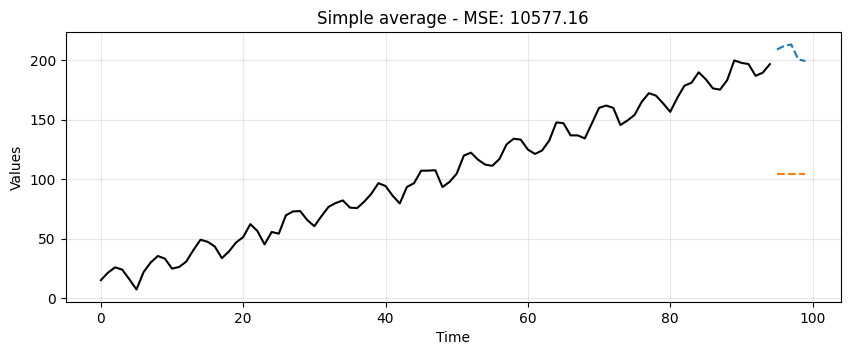

In [33]:
ax = run_sequence_plot(time[:-5], train, title=f"Simple average - MSE: {simple_mse:.2f}")
ax.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
ax.plot(time[-5:], simple_avg_preds, color='tab:orange', linestyle="--", label="preds");

### Single Exponential

In [34]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [196.61657923 196.61657923 196.61657923 196.61657923 196.61657923]
MSE:  136.2446911548019


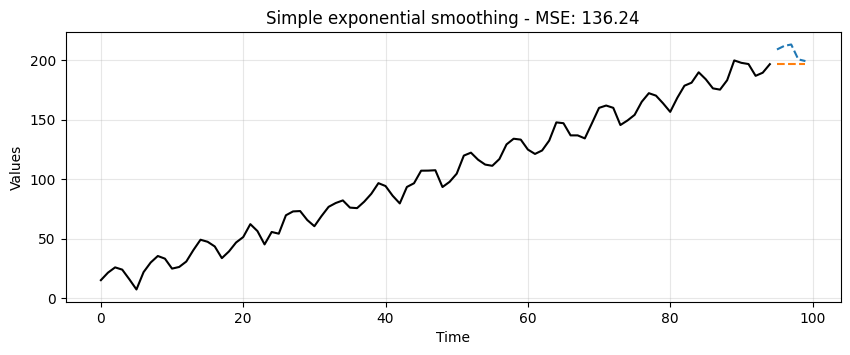

In [35]:
ax = run_sequence_plot(time[:-5], train, title=f"Simple exponential smoothing - MSE: {single_mse:.2f}")
ax.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
ax.plot(time[-5:], single_preds, color='tab:orange', linestyle="--", label="preds");

- This is certainly better than the simple average method but it's still pretty crude. 
- Notice how the forecast is just a horizontal line. 
- Single Exponential Smoothing cannot pick up neither trend nor seasonality.

### Double Exponential

In [36]:
from statsmodels.tsa.api import Holt

double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [198.62600845 200.63543764 202.64486683 204.65429603 206.66372522]
MSE:  82.9567699718211


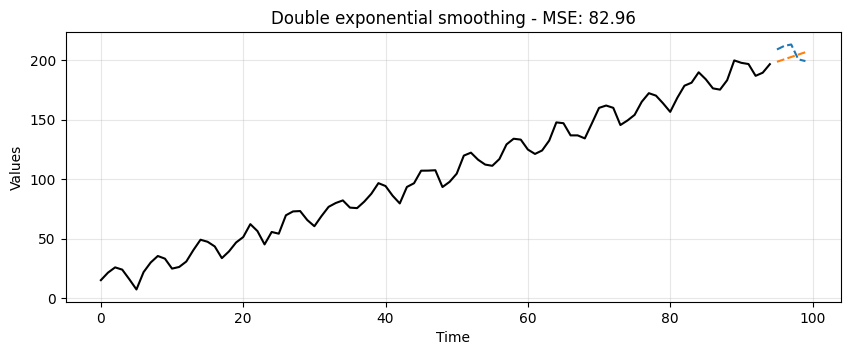

In [37]:
ax = run_sequence_plot(time[:-5], train, title=f"Double exponential smoothing - MSE: {double_mse:.2f}")
ax.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
ax.plot(time[-5:], double_preds, color='tab:orange', linestyle="--", label="preds");

- Double Exponential Smoothing can pickup on trend, which is exactly what we see here. 
- This is a significant leap but no quite yet the prediction we would like to get.

### Triple Exponential

In [38]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=13).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [204.46882537 207.03272136 215.7468254  209.8844677  202.24074733]
MSE:  28.93885391082436


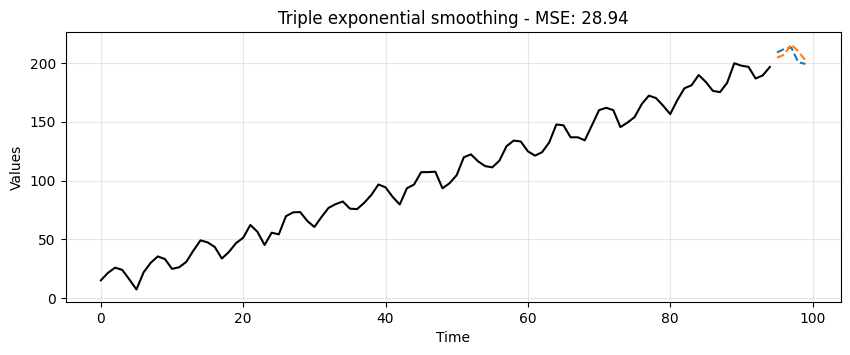

In [39]:
ax = run_sequence_plot(time[:-5], train, title=f"Triple exponential smoothing - MSE: {triple_mse:.2f}")
ax.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
ax.plot(time[-5:], triple_preds, color='tab:orange', linestyle="--", label="preds");

- Triple Exponential Smoothing picks up trend and seasonality. 
- Clearly, this is the most suitable approach for this data.
- We can summarize the results in the following table:

In [40]:
data_dict = {'MSE':[simple_mse, single_mse, double_mse, triple_mse]}
df = pd.DataFrame(data_dict, index=['simple', 'single', 'double', 'triple'])
print(df)

                 MSE
simple  10577.155939
single    136.244691
double     82.956770
triple     28.938854


---

## Summary

In this lecture we learned

1. What is smoothing and why it is necessary.
2. Some common smoothing techniques.
3. A basic understanding of how to smooth time series data with Python and generate forecasts.
---

## Exercises

Load the following two time series.

In [41]:
# Load the first time series
response = requests.get("https://zenodo.org/records/10897398/files/smoothing_ts1.npy?download=1")
response.raise_for_status()
smoothing_ts1 = np.load(BytesIO(response.content))
print(len(smoothing_ts1))

# Load the second time series
response = requests.get("https://zenodo.org/records/10897398/files/smoothing_ts4_4.npy?download=1")
response.raise_for_status()
smoothing_ts2 = np.load(BytesIO(response.content))
print(len(smoothing_ts2))

144
1000


Using on what you learned in this and in the previous lectures, do the following.

1. Create two time variables called `mytime1` and `mytime2` that starts at 0 and are as long as each dataset.
2. Split each dataset into train and test sets (as the test, use the last 5 observations).
3. Identify trend and seasonality, if present.
4. Identify if trend and/or seasonality are additive or multiplicative, if present.
5. Create smoothed model on the train set and use to forecast on the test set.
6. Calculate MSE on test data.
7. Plot training data, test data, and your model's forecast for each dataset.